In [1]:
import numpy as np
from sklearn.decomposition import PCA
from pyod.models.knn import KNN
import pandas as pd
from scipy.stats import mode
from sklearn.metrics import precision_score, recall_score, roc_auc_score

def calculate_knn_outlier_scores(data, n_samples, sample_fraction, n_components, n_neighbors, contamination):
    """
    Performs outlier detection using PCA and KNN with voting mechanism, returning final labels and scores.
    
    Parameters:
        data (numpy.ndarray): The input dataset.
        n_samples (int): Number of random samples to generate.
        sample_fraction (float): Fraction of the data to include in each sample.
        n_components (int): Number of PCA components.
        n_neighbors (int): Number of neighbors for KNN.
        contamination (float): Contamination level for KNN.
    
    Returns:
        numpy.ndarray: A binary array indicating whether each data point is an outlier (1) or not (0).
        numpy.ndarray: Average outlier scores for each data point.
    """
    n_data_points = data.shape[0]
    sample_size = int(n_data_points * sample_fraction)
    all_labels = np.zeros((n_samples, n_data_points), dtype=int)
    all_scores = np.zeros((n_samples, n_data_points), dtype=float)
    
    for i in range(n_samples):
        # Step 1: Random sampling
        sampled_indices = np.random.choice(n_data_points, sample_size, replace=False)
        sampled_data = data[sampled_indices]
        
        # Step 2: PCA transformation
        pca = PCA(n_components=n_components)
        reduced_data = pca.fit_transform(sampled_data)
        
        # Step 3: KNN outlier detection
        knn = KNN(n_neighbors=n_neighbors, contamination=contamination)
        knn.fit(reduced_data)
        
        # Assign outlier labels and scores to the full dataset
        full_reduced_data = pca.transform(data)
        labels = knn.predict(full_reduced_data)
        scores = knn.decision_function(full_reduced_data)  # Outlier scores
        
        all_labels[i] = labels
        all_scores[i] = scores
    
    # Step 4: Voting mechanism
    final_labels = mode(all_labels, axis=0)[0].flatten()
    average_scores = all_scores.mean(axis=0)
    
    return final_labels, average_scores

def evaluate_knn_outlier_detection(y_true, y_pred, y_scores):
    """
    Evaluates outlier detection performance using Precision, Recall, and AUC.
    
    Parameters:
        y_true (numpy.ndarray): Ground truth (0 for inliers, 1 for outliers).
        y_pred (numpy.ndarray): Predicted labels (0 for inliers, 1 for outliers).
        y_scores (numpy.ndarray): Outlier scores for each data point.
    
    Returns:
        Precision, Recall, and AUC scores.
    """
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)
    return  precision, recall, auc



C:\Users\asus\AppData\Local\Temp\ipykernel_6236\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_6236\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid thi

Maximum AUC: 0.556171395790124
Corresponding k: 12
Corresponding n_components: 15


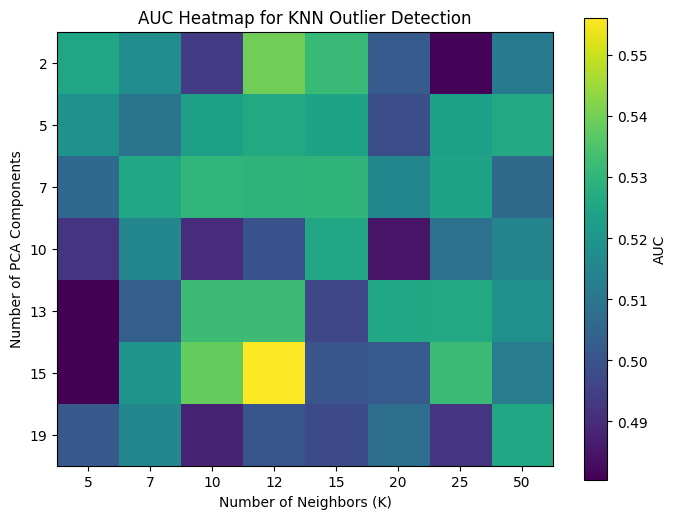

In [4]:
# KNN
# dataset: Annthyroid_norm_02_v01.csv
import numpy as np
import matplotlib.pyplot as plt

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Annthyroid\\Annthyroid_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values

# Define the hyperparameter ranges
k_values = [5, 7, 10, 12, 15, 20, 25, 50]  # Number of neighbors
n_components_values = [2, 5, 7, 10, 13, 15, 19]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            data, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])
                                    
max_auc_index = np.argmax(results['auc'])

# Retrieve the corresponding n_components, k, and AUC
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the results
print(f"Maximum AUC: {max_auc}")
print(f"Corresponding k: {best_k}")
print(f"Corresponding n_components: {best_n_components}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection')
plt.show()


Number of training samples: 5440
Testing K values: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73]


C:\Users\asus\AppData\Local\Temp\ipykernel_16096\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_16096\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC on Validation Set: 0.6296018657337998
Best k (Number of Neighbors): 17
Best n_components (PCA): 7


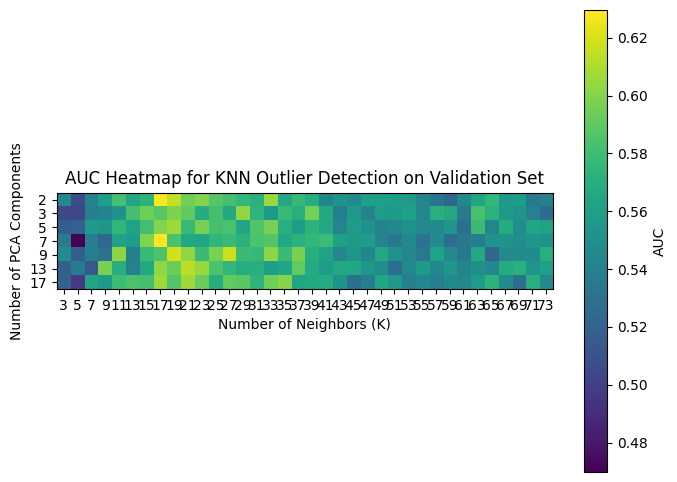

In [2]:
# KNN
# dataset: Annthyroid_norm_02_v01.csv
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\Annthyroid\\Annthyroid_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 17]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


Number of training samples: 4080
Testing K values: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63]


C:\Users\asus\AppData\Local\Temp\ipykernel_13432\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_13432\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC on Validation Set: 0.5456364091022755
Best k (Number of Neighbors): 5
Best n_components (PCA): 7


C:\Users\asus\AppData\Local\Temp\ipykernel_13432\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


Test Set Performance:
Precision: 0.08695652173913043
Recall: 0.14814814814814814
AUC: 0.525098561830196


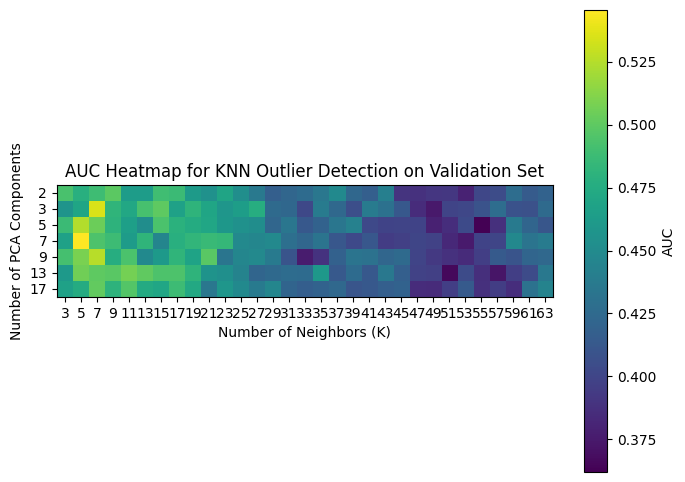

In [6]:
# KNN
# dataset: Annthyroid_norm_02_v01.csv
# tvt 60 20 20
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Annthyroid\\Annthyroid_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.4, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 17]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results from validation
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"Test Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


Number of training samples: 4760
Testing K values: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67]


C:\Users\asus\AppData\Local\Temp\ipykernel_13400\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_13400\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Best Hyperparameters (from Cross-Validation):
n_components (PCA): 3
k (Number of Neighbors): 61
Average AUC (Cross-Validation): 0.538950201548565


C:\Users\asus\AppData\Local\Temp\ipykernel_13400\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()



Test Set Performance:
Precision: 0.0
Recall: 0.0
AUC: 0.3956772784019975


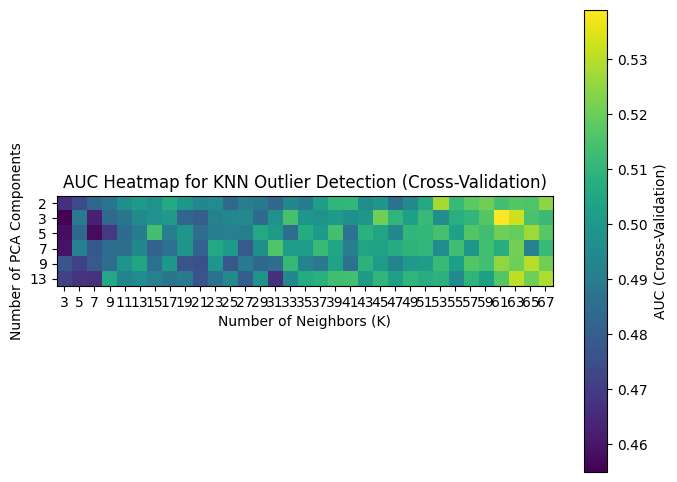

In [9]:
# KNN
# dataset: Annthyroid_norm_02_v01.csv
# cross validation  
# tvt 70 18 12
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Annthyroid\\Annthyroid_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (70% train, 18% validation, 12% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13]  # Number of PCA components

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
cv_results = []  # To store cross-validation results

# Perform cross-validation
for n_components in n_components_values:
    for k in k_values:
        fold_aucs = []  # To store AUCs for each fold
        for train_idx, val_idx in kf.split(X_train):
            # Split data into training and validation folds
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Calculate KNN outlier scores on the training fold
            _, outlier_scores_fold = calculate_knn_outlier_scores(
                X_train_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Evaluate the performance on the validation fold
            _, val_outlier_scores_fold = calculate_knn_outlier_scores(
                X_val_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Compute the AUC for this fold
            _, _, auc_fold = evaluate_knn_outlier_detection(y_val_fold, _, val_outlier_scores_fold)
            fold_aucs.append(auc_fold)
        
        # Store the average AUC for this hyperparameter combination
        avg_auc = np.mean(fold_aucs)
        cv_results.append((n_components, k, avg_auc))

# Convert CV results to a structured array for analysis
cv_results = np.array(cv_results, dtype=[('n_components', int), ('k', int), ('auc', float)])

# Find the best parameters based on the maximum average AUC
best_index = np.argmax(cv_results['auc'])
best_n_components = cv_results['n_components'][best_index]
best_k = cv_results['k'][best_index]
best_auc = cv_results['auc'][best_index]

print(f"Best Hyperparameters (from Cross-Validation):")
print(f"n_components (PCA): {best_n_components}")
print(f"k (Number of Neighbors): {best_k}")
print(f"Average AUC (Cross-Validation): {best_auc}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"\nTest Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the cross-validation results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        matching_auc = cv_results[(cv_results['n_components'] == n_components) & 
                                  (cv_results['k'] == k)]['auc']
        auc_matrix[i, j] = matching_auc[0] if len(matching_auc) > 0 else 0

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC (Cross-Validation)')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection (Cross-Validation)')
plt.show()


In [5]:
# KNN
# dataset: Annthyroid_norm_02_v01.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Annthyroid\\Annthyroid_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)


C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


Precision: 0.0
Recall: 0.0
AUC: 0.48476898636423815


In [12]:
# KNN
# dataset: Arrhythmia_withoutdupl_norm_02_v01.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Arrhythmia\\Arrhythmia_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=7, n_neighbors=7, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)


Precision: 0.125
Recall: 0.3333333333333333
AUC: 0.5177595628415301


C:\Users\asus\AppData\Local\Temp\ipykernel_6236\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC: 0.7950819672131147
Corresponding k: 5
Corresponding n_components: 10


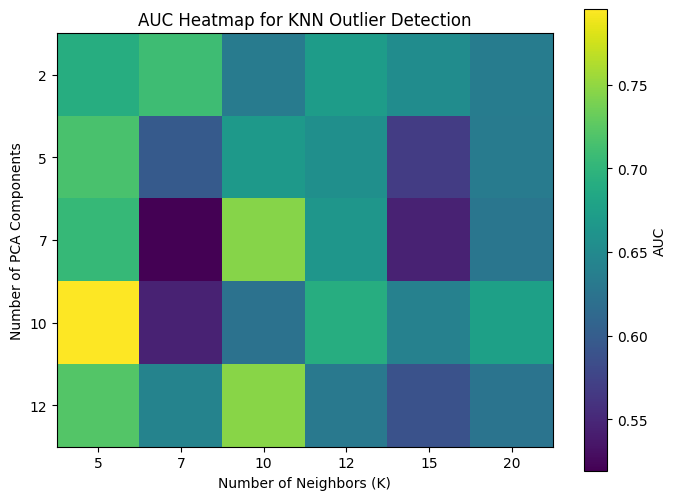

In [7]:
# KNN
# dataset: Arrhythmia_withoutdupl_norm_02_v01.csv
import numpy as np
import matplotlib.pyplot as plt

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Arrhythmia\\Arrhythmia_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values

# Define the hyperparameter ranges
k_values = [5, 7, 10, 12, 15, 20]  # Number of neighbors
n_components_values = [2, 5, 7, 10, 12]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            data, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

max_auc_index = np.argmax(results['auc'])

# Retrieve the corresponding n_components, k, and AUC
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the results
print(f"Maximum AUC: {max_auc}")
print(f"Corresponding k: {best_k}")
print(f"Corresponding n_components: {best_n_components}")


# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection')
plt.show()


Number of training samples: 197
Testing K values: [3, 5, 7, 9, 11, 13]


C:\Users\asus\AppData\Local\Temp\ipykernel_10332\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10332\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC on Validation Set: 0.9591836734693877
Best k (Number of Neighbors): 5
Best n_components (PCA): 2


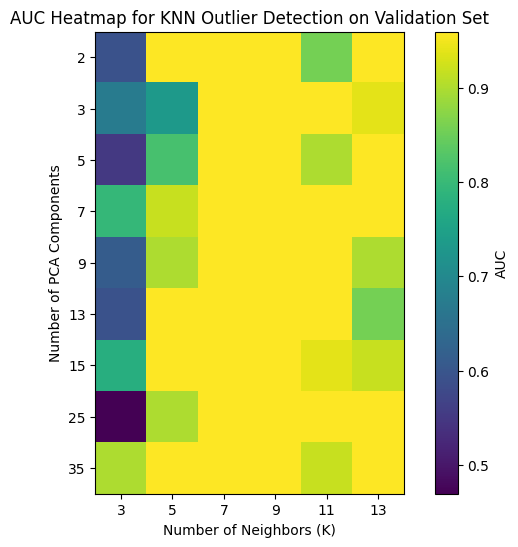

In [4]:
# KNN
# dataset: Arrhythmia_withoutdupl_norm_02_v01.csv
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\Arrhythmia\\Arrhythmia_withoutdupl_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 15, 25, 35]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


In [ ]:
# KNN
# dataset: Arrhythmia_withoutdupl_norm_02_v01.csv
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\Arrhythmia\\Arrhythmia_withoutdupl_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (60% train, 24% validation, 16% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.4, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 15, 25, 35]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


In [13]:
# KNN
# dataset: Arrhythmia_withoutdupl_norm_02_v01.csv
# cross validation
# tvt 70 18 12
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\Arrhythmia\\Arrhythmia_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.4, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 15, 25, 35]  # Number of PCA components

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
cv_results = []  # To store cross-validation results

# Perform cross-validation
for n_components in n_components_values:
    for k in k_values:
        fold_aucs = []  # To store AUCs for each fold
        for train_idx, val_idx in kf.split(X_train):
            # Split data into training and validation folds
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Calculate KNN outlier scores on the training fold
            _, outlier_scores_fold = calculate_knn_outlier_scores(
                X_train_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Evaluate the performance on the validation fold
            _, val_outlier_scores_fold = calculate_knn_outlier_scores(
                X_val_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Compute the AUC for this fold
            _, _, auc_fold = evaluate_knn_outlier_detection(y_val_fold, _, val_outlier_scores_fold)
            fold_aucs.append(auc_fold)
        
        # Store the average AUC for this hyperparameter combination
        avg_auc = np.mean(fold_aucs)
        cv_results.append((n_components, k, avg_auc))

# Convert CV results to a structured array for analysis
cv_results = np.array(cv_results, dtype=[('n_components', int), ('k', int), ('auc', float)])

# Find the best parameters based on the maximum average AUC
best_index = np.argmax(cv_results['auc'])
best_n_components = cv_results['n_components'][best_index]
best_k = cv_results['k'][best_index]
best_auc = cv_results['auc'][best_index]

print(f"Best Hyperparameters (from Cross-Validation):")
print(f"n_components (PCA): {best_n_components}")
print(f"k (Number of Neighbors): {best_k}")
print(f"Average AUC (Cross-Validation): {best_auc}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"\nTest Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the cross-validation results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        matching_auc = cv_results[(cv_results['n_components'] == n_components) & 
                                  (cv_results['k'] == k)]['auc']
        auc_matrix[i, j] = matching_auc[0] if len(matching_auc) > 0 else 0

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC (Cross-Validation)')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection (Cross-Validation)')
plt.show()


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [14]:
# stratified kfold cv
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\Arrhythmia\\Arrhythmia_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.4, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 15, 25, 35]  # Number of PCA components

# Stratified K-fold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold stratified cross-validation
cv_results = []  # To store cross-validation results

# Perform stratified cross-validation
for n_components in n_components_values:
    for k in k_values:
        fold_aucs = []  # To store AUCs for each fold
        for train_idx, val_idx in skf.split(X_train, y_train):
            # Split data into training and validation folds
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Calculate KNN outlier scores on the training fold
            _, outlier_scores_fold = calculate_knn_outlier_scores(
                X_train_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Evaluate the performance on the validation fold
            _, val_outlier_scores_fold = calculate_knn_outlier_scores(
                X_val_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Compute the AUC for this fold
            _, _, auc_fold = evaluate_knn_outlier_detection(y_val_fold, _, val_outlier_scores_fold)
            fold_aucs.append(auc_fold)
        
        # Store the average AUC for this hyperparameter combination
        avg_auc = np.mean(fold_aucs)
        cv_results.append((n_components, k, avg_auc))

# Convert CV results to a structured array for analysis
cv_results = np.array(cv_results, dtype=[('n_components', int), ('k', int), ('auc', float)])

# Find the best parameters based on the maximum average AUC
best_index = np.argmax(cv_results['auc'])
best_n_components = cv_results['n_components'][best_index]
best_k = cv_results['k'][best_index]
best_auc = cv_results['auc'][best_index]

print(f"Best Hyperparameters (from Cross-Validation):")
print(f"n_components (PCA): {best_n_components}")
print(f"k (Number of Neighbors): {best_k}")
print(f"Average AUC (Cross-Validation): {best_auc}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"\nTest Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the cross-validation results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        matching_auc = cv_results[(cv_results['n_components'] == n_components) & 
                                  (cv_results['k'] == k)]['auc']
        auc_matrix[i, j] = matching_auc[0] if len(matching_auc) > 0 else 0

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC (Cross-Validation)')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection (Cross-Validation)')
plt.show()


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [2]:
# KNN
# dataset: Arrhythmia_withoutdupl_norm_02_v01.csv
# cross validation
# tvt 70 18 12
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\Arrhythmia\\Arrhythmia_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.4, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 15, 25, 35]  # Number of PCA components

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
cv_results = []  # To store cross-validation results

# Perform cross-validation
for n_components in n_components_values:
    for k in k_values:
        fold_aucs = []  # To store AUCs for each fold
        for train_idx, val_idx in kf.split(X_train):
            # Split data into training and validation folds
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Calculate KNN outlier scores on the training fold
            _, outlier_scores_fold = calculate_knn_outlier_scores(
                X_train_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Evaluate the performance on the validation fold
            _, val_outlier_scores_fold = calculate_knn_outlier_scores(
                X_val_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Compute the AUC for this fold
            _, _, auc_fold = evaluate_knn_outlier_detection(y_val_fold, _, val_outlier_scores_fold)
            fold_aucs.append(auc_fold)
        
        # Store the average AUC for this hyperparameter combination
        avg_auc = np.mean(fold_aucs)
        cv_results.append((n_components, k, avg_auc))

# Convert CV results to a structured array for analysis
cv_results = np.array(cv_results, dtype=[('n_components', int), ('k', int), ('auc', float)])

# Find the best parameters based on the maximum average AUC
best_index = np.argmax(cv_results['auc'])
best_n_components = cv_results['n_components'][best_index]
best_k = cv_results['k'][best_index]
best_auc = cv_results['auc'][best_index]

print(f"Best Hyperparameters (from Cross-Validation):")
print(f"n_components (PCA): {best_n_components}")
print(f"k (Number of Neighbors): {best_k}")
print(f"Average AUC (Cross-Validation): {best_auc}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"\nTest Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the cross-validation results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        matching_auc = cv_results[(cv_results['n_components'] == n_components) & 
                                  (cv_results['k'] == k)]['auc']
        auc_matrix[i, j] = matching_auc[0] if len(matching_auc) > 0 else 0

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC (Cross-Validation)')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection (Cross-Validation)')
plt.show()


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [8]:
# KNN with Combined Validation-Test Split
# dataset: Arrhythmia_withoutdupl_norm_02_v01.csv
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\Arrhythmia\\Arrhythmia_withoutdupl_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Dynamically calculate odd K values based on the dataset size
N_data = len(data)  # Number of samples
max_k = int(math.sqrt(N_data))  # sqrt(N) for the dataset
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of samples:", N_data)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 15, 25, 35]  # Number of PCA components

# Cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
cv_results = []  # To store cross-validation results

# Perform k-fold cross-validation
for n_components in n_components_values:
    for k in k_values:
        combined_aucs = []  # To store AUCs for the combined validation-test set
        combined_precisions = []
        combined_recalls = []
        
        for train_idx, eval_idx in kf.split(data, labels):
            # Split data into training and combined evaluation sets
            X_train_fold, X_eval_fold = data[train_idx], data[eval_idx]
            y_train_fold, y_eval_fold = labels[train_idx], labels[eval_idx]
            
            # Calculate KNN outlier scores on the training fold
            _, outlier_scores_train = calculate_knn_outlier_scores(
                X_train_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Evaluate the performance on the combined evaluation set
            _, eval_outlier_scores = calculate_knn_outlier_scores(
                X_eval_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Compute the metrics for this fold
            auc_fold = roc_auc_score(y_eval_fold, eval_outlier_scores)
            precision_fold = precision_score(y_eval_fold, eval_outlier_scores > 0.5)
            recall_fold = recall_score(y_eval_fold, eval_outlier_scores > 0.5)
            
            combined_aucs.append(auc_fold)
            combined_precisions.append(precision_fold)
            combined_recalls.append(recall_fold)
        
        # Store the average metrics for this hyperparameter combination
        avg_auc = np.mean(combined_aucs)
        avg_precision = np.mean(combined_precisions)
        avg_recall = np.mean(combined_recalls)
        cv_results.append((n_components, k, avg_auc, avg_precision, avg_recall))

# Convert CV results to a structured array for analysis
cv_results = np.array(cv_results, dtype=[
    ('n_components', int), ('k', int), 
    ('auc', float), ('precision', float), ('recall', float)
])

# Find the best parameters based on the maximum average AUC
best_index = np.argmax(cv_results['auc'])
best_n_components = cv_results['n_components'][best_index]
best_k = cv_results['k'][best_index]
best_auc = cv_results['auc'][best_index]
best_precision = cv_results['precision'][best_index]
best_recall = cv_results['recall'][best_index]

print(f"Best Hyperparameters (from Cross-Validation):")
print(f"n_components (PCA): {best_n_components}")
print(f"k (Number of Neighbors): {best_k}")
print(f"Average AUC: {best_auc}")
print(f"Average Precision: {best_precision}")
print(f"Average Recall: {best_recall}")

# Visualize the cross-validation results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        matching_auc = cv_results[(cv_results['n_components'] == n_components) & 
                                  (cv_results['k'] == k)]['auc']
        auc_matrix[i, j] = matching_auc[0] if len(matching_auc) > 0 else 0

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC (Cross-Validation)')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection (Cross-Validation)')
plt.show()


Number of samples: 247
Testing K values: [3, 5, 7, 9, 11, 13, 15]


c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\asus\AppData\Local\Temp\ipykernel_16496\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_16496\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behav

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

Number of training samples: 123
Testing K values: [3, 5, 7, 9, 11]


C:\Users\asus\AppData\Local\Temp\ipykernel_10332\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10332\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC on Validation Set: 0.9647058823529412
Best k (Number of Neighbors): 3
Best n_components (PCA): 3
Test Set Performance:
Precision: 0.0
Recall: 0.0
AUC: 1.0


C:\Users\asus\AppData\Local\Temp\ipykernel_10332\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


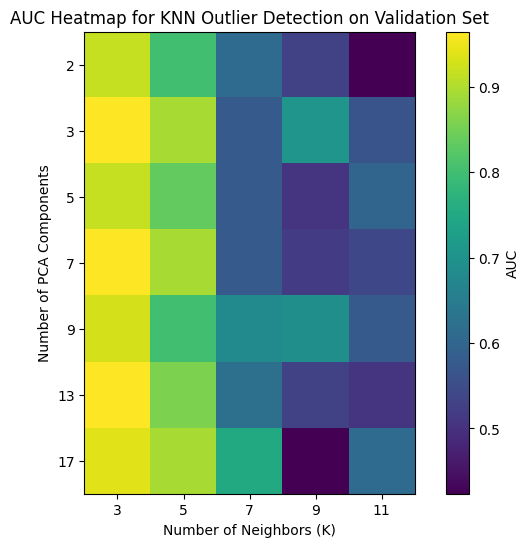

In [24]:
# KNN
# dataset: Arrhythmia_withoutdupl_norm_02_v01.csv
# tvt 60 20 20
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


file_path = "G:\\Nazanin\\B project\\code\\dataset\\Arrhythmia\\Arrhythmia_withoutdupl_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.5, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 17]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results from validation
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"Test Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


In [8]:
# KNN
# dataset: Cardiotocography_norm_02_v01.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Cardiotocography\\Cardiotocography_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)



Precision: 0.3013698630136986
Recall: 0.6875
AUC: 0.9493013595166163


C:\Users\asus\AppData\Local\Temp\ipykernel_6236\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC: 0.9601774924471299
Corresponding k: 5
Corresponding n_components: 7


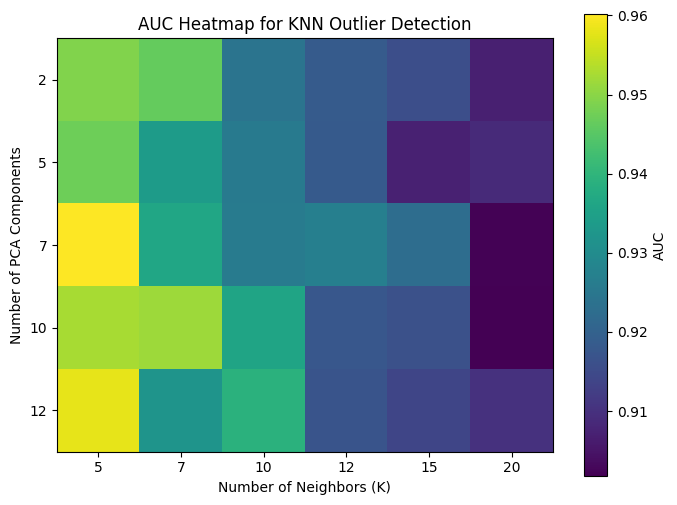

In [19]:
# KNN
# dataset: Cardiotocography_norm_02_v01.csv
import numpy as np
import matplotlib.pyplot as plt

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Cardiotocography\\Cardiotocography_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values

# Define the hyperparameter ranges
k_values = [5, 7, 10, 12, 15, 20]  # Number of neighbors
n_components_values = [2, 5, 7, 10, 12]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            data, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])
                                    
max_auc_index = np.argmax(results['auc'])

# Retrieve the corresponding n_components, k, and AUC
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the results
print(f"Maximum AUC: {max_auc}")
print(f"Corresponding k: {best_k}")
print(f"Corresponding n_components: {best_n_components}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection')
plt.show()


Number of training samples: 1012
Testing K values: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]


C:\Users\asus\AppData\Local\Temp\ipykernel_13432\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_13432\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC on Validation Set: 0.9823766364551862
Best k (Number of Neighbors): 9
Best n_components (PCA): 7


C:\Users\asus\AppData\Local\Temp\ipykernel_13432\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


Test Set Performance:
Precision: 0.043478260869565216
Recall: 0.14285714285714285
AUC: 0.7686663789382823


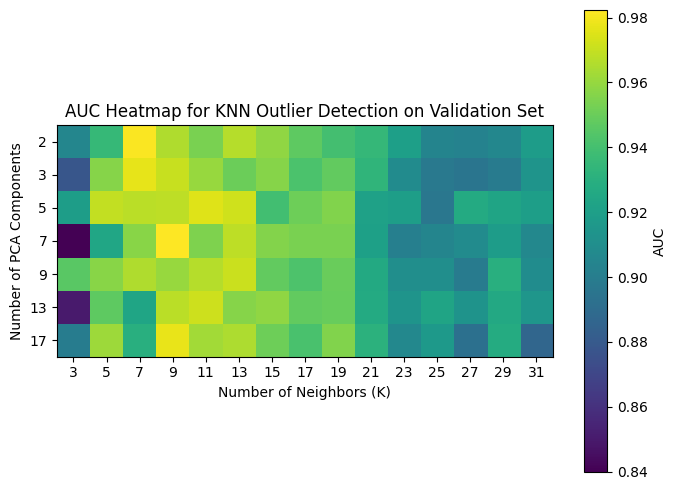

In [4]:
# KNN
# dataset: Cardiotocography_norm_02_v01.csv
# tvt 60 20 20
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


file_path = "G:\\Nazanin\\B project\\code\\dataset\\Cardiotocography\\Cardiotocography_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.4, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 17]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results from validation
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"Test Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


Number of training samples: 1180
Testing K values: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33]


C:\Users\asus\AppData\Local\Temp\ipykernel_13400\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_13400\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Best Hyperparameters (from Cross-Validation):
n_components (PCA): 13
k (Number of Neighbors): 3
Average AUC (Cross-Validation): 0.8315626076975008


C:\Users\asus\AppData\Local\Temp\ipykernel_13400\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()



Test Set Performance:
Precision: 0.0
Recall: 0.0
AUC: 0.8994974874371859


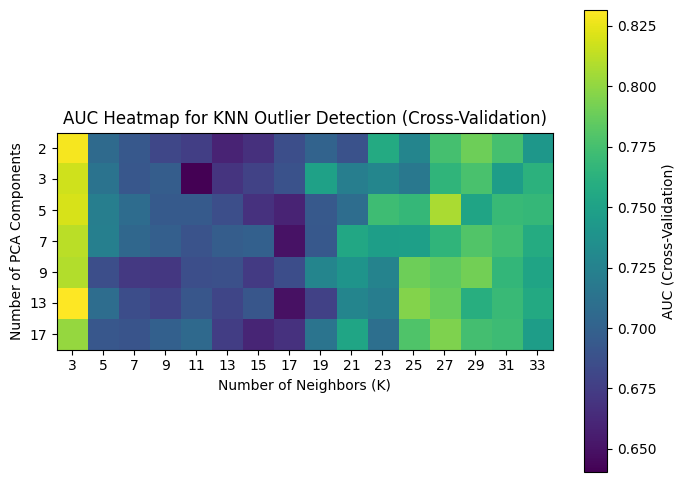

In [8]:
# KNN
# dataset: Cardiotocography_norm_02_v01.csv
# tvt 70 18 12
# cross validation
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\Cardiotocography\\Cardiotocography_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (70% train, 18% validation, 12% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 17]  # Number of PCA components

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
cv_results = []  # To store cross-validation results

# Perform cross-validation
for n_components in n_components_values:
    for k in k_values:
        fold_aucs = []  # To store AUCs for each fold
        for train_idx, val_idx in kf.split(X_train):
            # Split data into training and validation folds
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Calculate KNN outlier scores on the training fold
            _, outlier_scores_fold = calculate_knn_outlier_scores(
                X_train_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Evaluate the performance on the validation fold
            _, val_outlier_scores_fold = calculate_knn_outlier_scores(
                X_val_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Compute the AUC for this fold
            _, _, auc_fold = evaluate_knn_outlier_detection(y_val_fold, _, val_outlier_scores_fold)
            fold_aucs.append(auc_fold)
        
        # Store the average AUC for this hyperparameter combination
        avg_auc = np.mean(fold_aucs)
        cv_results.append((n_components, k, avg_auc))

# Convert CV results to a structured array for analysis
cv_results = np.array(cv_results, dtype=[('n_components', int), ('k', int), ('auc', float)])

# Find the best parameters based on the maximum average AUC
best_index = np.argmax(cv_results['auc'])
best_n_components = cv_results['n_components'][best_index]
best_k = cv_results['k'][best_index]
best_auc = cv_results['auc'][best_index]

print(f"Best Hyperparameters (from Cross-Validation):")
print(f"n_components (PCA): {best_n_components}")
print(f"k (Number of Neighbors): {best_k}")
print(f"Average AUC (Cross-Validation): {best_auc}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"\nTest Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the cross-validation results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        matching_auc = cv_results[(cv_results['n_components'] == n_components) & 
                                  (cv_results['k'] == k)]['auc']
        auc_matrix[i, j] = matching_auc[0] if len(matching_auc) > 0 else 0

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC (Cross-Validation)')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection (Cross-Validation)')
plt.show()


In [9]:
# KNN
# dataset: HeartDisease_withoutdupl_norm_02_v01.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\HeartDisease\\HeartDisease_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)


Precision: 0.0
Recall: 0.0
AUC: 0.4666666666666667


C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC: 0.6333333333333333
Corresponding k: 5
Corresponding n_components: 12


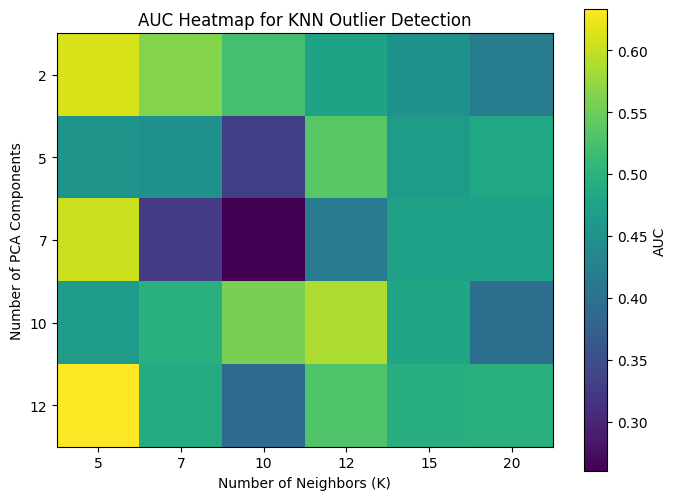

In [10]:
# KNN
# dataset: HeartDisease_withoutdupl_norm_02_v01.csv
import numpy as np
import matplotlib.pyplot as plt

file_path = "G:\\Nazanin\\B project\\code\\dataset\\HeartDisease\\HeartDisease_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values

# Define the hyperparameter ranges
k_values = [5, 7, 10, 12, 15, 20]  # Number of neighbors
n_components_values = [2, 5, 7, 10, 12]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            data, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

max_auc_index = np.argmax(results['auc'])

# Retrieve the corresponding n_components, k, and AUC
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the results
print(f"Maximum AUC: {max_auc}")
print(f"Corresponding k: {best_k}")
print(f"Corresponding n_components: {best_n_components}")


# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection')
plt.show()


Number of training samples: 106
Testing K values: [3, 5, 7, 9]


C:\Users\asus\AppData\Local\Temp\ipykernel_9788\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_9788\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid thi

Maximum AUC on Validation Set: 0.8888888888888888
Best k (Number of Neighbors): 3
Best n_components (PCA): 3


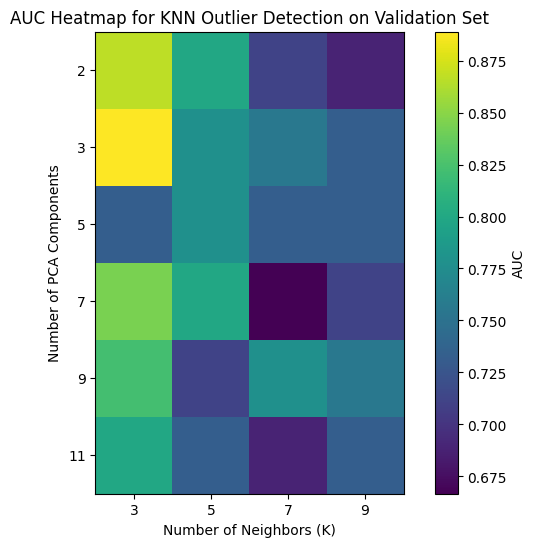

In [3]:
# KNN
# dataset: HeartDisease_withoutdupl_norm_02_v01.csv
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\HeartDisease\\HeartDisease_withoutdupl_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into training and validation sets (70% train, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 11]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


In [11]:
# KNN
# dataset: HeartDisease_withoutdupl_norm_02_v01.csv
# tvt 70 18 12
# cross validation
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\HeartDisease\\HeartDisease_withoutdupl_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (70% train, 18% validation, 12% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 11]  # Number of PCA components

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
cv_results = []  # To store cross-validation results

# Perform cross-validation
for n_components in n_components_values:
    for k in k_values:
        fold_aucs = []  # To store AUCs for each fold
        for train_idx, val_idx in kf.split(X_train):
            # Split data into training and validation folds
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Calculate KNN outlier scores on the training fold
            _, outlier_scores_fold = calculate_knn_outlier_scores(
                X_train_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Evaluate the performance on the validation fold
            _, val_outlier_scores_fold = calculate_knn_outlier_scores(
                X_val_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Compute the AUC for this fold
            _, _, auc_fold = evaluate_knn_outlier_detection(y_val_fold, _, val_outlier_scores_fold)
            fold_aucs.append(auc_fold)
        
        # Store the average AUC for this hyperparameter combination
        avg_auc = np.mean(fold_aucs)
        cv_results.append((n_components, k, avg_auc))

# Convert CV results to a structured array for analysis
cv_results = np.array(cv_results, dtype=[('n_components', int), ('k', int), ('auc', float)])

# Find the best parameters based on the maximum average AUC
best_index = np.argmax(cv_results['auc'])
best_n_components = cv_results['n_components'][best_index]
best_k = cv_results['k'][best_index]
best_auc = cv_results['auc'][best_index]

print(f"Best Hyperparameters (from Cross-Validation):")
print(f"n_components (PCA): {best_n_components}")
print(f"k (Number of Neighbors): {best_k}")
print(f"Average AUC (Cross-Validation): {best_auc}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"\nTest Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the cross-validation results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        matching_auc = cv_results[(cv_results['n_components'] == n_components) & 
                                  (cv_results['k'] == k)]['auc']
        auc_matrix[i, j] = matching_auc[0] if len(matching_auc) > 0 else 0

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC (Cross-Validation)')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection (Cross-Validation)')
plt.show()


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [11]:
# KNN
# dataset: Hepatitis_withoutdupl_norm_05_v01.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Hepatitis\\Hepatitis_withoutdupl_norm_05_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)


Precision: 0.0
Recall: 0.0
AUC: 0.7525252525252525


C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC: 0.8131313131313131
Corresponding k: 10
Corresponding n_components: 12


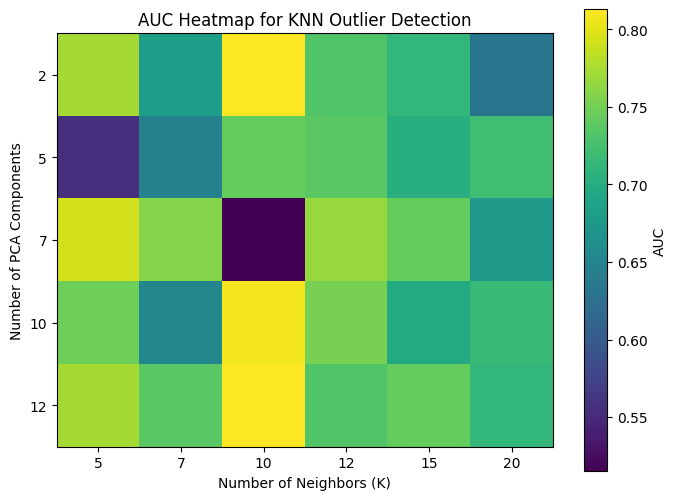

In [12]:
# KNN
# dataset: Hepatitis_withoutdupl_norm_05_v01.csv
import numpy as np
import matplotlib.pyplot as plt

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Hepatitis\\Hepatitis_withoutdupl_norm_05_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values

# Define the hyperparameter ranges
k_values = [5, 7, 10, 12, 15, 20]  # Number of neighbors
n_components_values = [2, 5, 7, 10, 12]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            data, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

max_auc_index = np.argmax(results['auc'])

# Retrieve the corresponding n_components, k, and AUC
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the results
print(f"Maximum AUC: {max_auc}")
print(f"Corresponding k: {best_k}")
print(f"Corresponding n_components: {best_n_components}")


# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection')
plt.show()


Number of training samples: 48
Testing K values: [3, 5, 7, 9]


C:\Users\asus\AppData\Local\Temp\ipykernel_2512\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_2512\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid thi

Maximum AUC on Validation Set: 0.95
Best k (Number of Neighbors): 9
Best n_components (PCA): 2


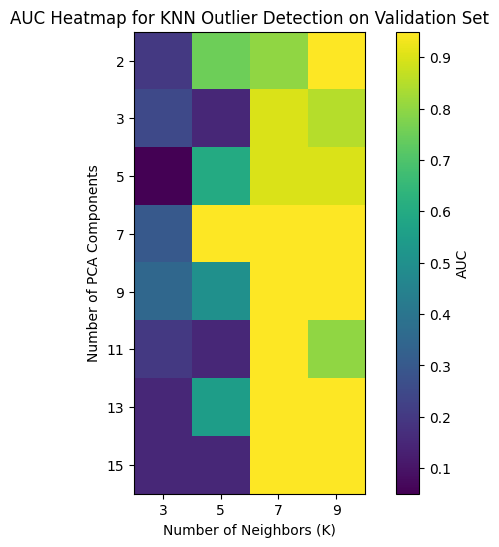

In [3]:
# KNN
# dataset: Hepatitis_withoutdupl_norm_05_v01.csv
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\Hepatitis\\Hepatitis_withoutdupl_norm_05_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into training and validation sets (70% train, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values
k_values.append(7)
k_values.append(9)
print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 11, 13, 15]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


In [13]:
# KNN
# dataset: Lymphography_withoutdupl_norm_1ofn.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Lymphography\\Lymphography_withoutdupl_norm_1ofn.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-2].values
    
    # Separate labels (last column)
labels = df.iloc[:, -2].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)


Precision: 0.0
Recall: 0.0
AUC: 0.6477541371158393


C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC: 0.9515366430260047
Corresponding k: 20
Corresponding n_components: 12


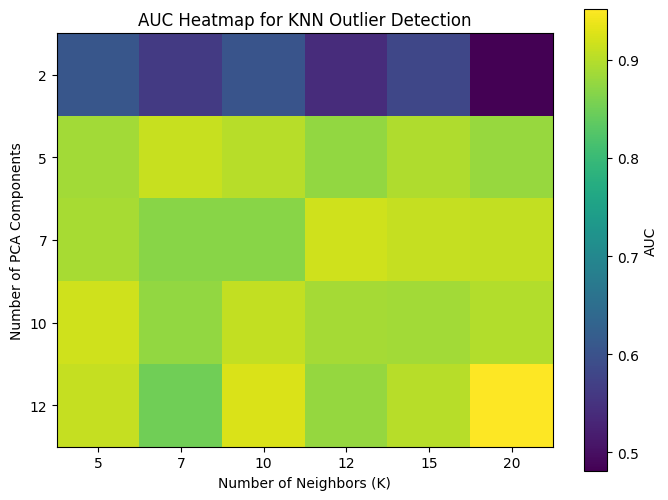

In [14]:
# KNN
# dataset: Lymphography_withoutdupl_norm_1ofn.csv
import numpy as np
import matplotlib.pyplot as plt

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Lymphography\\Lymphography_withoutdupl_norm_1ofn.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-2].values
    
    # Separate labels (last column)
labels = df.iloc[:, -2].values

# Define the hyperparameter ranges
k_values = [5, 7, 10, 12, 15, 20]  # Number of neighbors
n_components_values = [2, 5, 7, 10, 12]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            data, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

max_auc_index = np.argmax(results['auc'])

# Retrieve the corresponding n_components, k, and AUC
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the results
print(f"Maximum AUC: {max_auc}")
print(f"Corresponding k: {best_k}")
print(f"Corresponding n_components: {best_n_components}")


# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection')
plt.show()


Number of training samples: 117
Testing K values: [3, 5, 7, 9]


C:\Users\asus\AppData\Local\Temp\ipykernel_8160\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_8160\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid thi

Maximum AUC on Validation Set: 1.0
Best k (Number of Neighbors): 5
Best n_components (PCA): 2


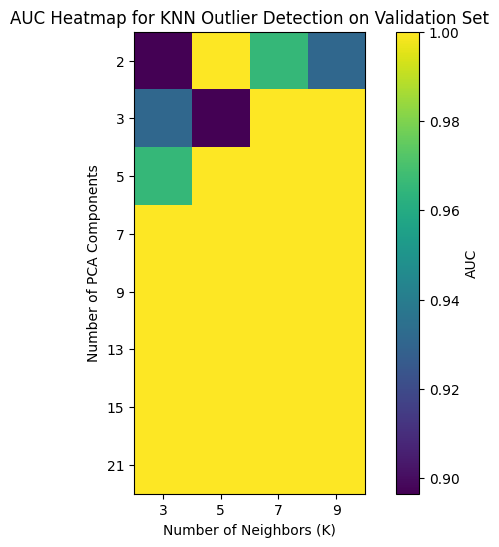

In [9]:
# KNN
# dataset: Lymphography_withoutdupl_norm_1ofn.csv
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\Lymphography\\Lymphography_withoutdupl_norm_1ofn.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-2].values

# Separate labels (last column)
labels = df.iloc[:, -2].values

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values
#k_values.append(7)
#k_values.append(9)
print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 15, 21]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


In [19]:
# KNN
# dataset: Lymphography_withoutdupl_norm_1ofn.csv
# tvt 70 18 12
# cross validation
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\Lymphography\\Lymphography_withoutdupl_norm_1ofn.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-2].values

# Separate labels (last column)
labels = df.iloc[:, -2].values

# Split the data into train, validation, and test sets (70% train, 18% validation, 12% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 11]  # Number of PCA components

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
cv_results = []  # To store cross-validation results

# Perform cross-validation
for n_components in n_components_values:
    for k in k_values:
        fold_aucs = []  # To store AUCs for each fold
        for train_idx, val_idx in kf.split(X_train):
            # Split data into training and validation folds
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Calculate KNN outlier scores on the training fold
            _, outlier_scores_fold = calculate_knn_outlier_scores(
                X_train_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Evaluate the performance on the validation fold
            _, val_outlier_scores_fold = calculate_knn_outlier_scores(
                X_val_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Compute the AUC for this fold
            _, _, auc_fold = evaluate_knn_outlier_detection(y_val_fold, _, val_outlier_scores_fold)
            fold_aucs.append(auc_fold)
        
        # Store the average AUC for this hyperparameter combination
        avg_auc = np.mean(fold_aucs)
        cv_results.append((n_components, k, avg_auc))

# Convert CV results to a structured array for analysis
cv_results = np.array(cv_results, dtype=[('n_components', int), ('k', int), ('auc', float)])

# Find the best parameters based on the maximum average AUC
best_index = np.argmax(cv_results['auc'])
best_n_components = cv_results['n_components'][best_index]
best_k = cv_results['k'][best_index]
best_auc = cv_results['auc'][best_index]

print(f"Best Hyperparameters (from Cross-Validation):")
print(f"n_components (PCA): {best_n_components}")
print(f"k (Number of Neighbors): {best_k}")
print(f"Average AUC (Cross-Validation): {best_auc}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"\nTest Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the cross-validation results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        matching_auc = cv_results[(cv_results['n_components'] == n_components) & 
                                  (cv_results['k'] == k)]['auc']
        auc_matrix[i, j] = matching_auc[0] if len(matching_auc) > 0 else 0

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC (Cross-Validation)')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection (Cross-Validation)')
plt.show()


Number of training samples: 102
Testing K values: [3, 5, 7, 9]


C:\Users\asus\AppData\Local\Temp\ipykernel_16496\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_16496\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

Number of training samples: 73
Testing K values: [3, 5, 7]


C:\Users\asus\AppData\Local\Temp\ipykernel_10332\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10332\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC on Validation Set: 1.0
Best k (Number of Neighbors): 7
Best n_components (PCA): 8
Test Set Performance:
Precision: 0.5
Recall: 1.0
AUC: 1.0


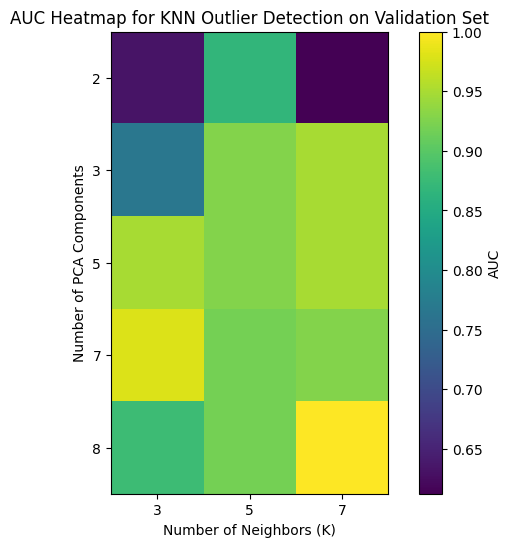

In [34]:
# KNN
# dataset: Lymphography_withoutdupl_norm_1ofn.csv
# tvt 60 20 20
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


file_path = "G:\\Nazanin\\B project\\code\\dataset\\Lymphography\\Lymphography_withoutdupl_norm_1ofn.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-2].values

# Separate labels (last column)
labels = df.iloc[:, -2].values

# Split the data into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.5, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 8]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results from validation
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"Test Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


In [18]:
# KNN
# dataset: Parkinson_withoutdupl_norm_05_v01.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Parkinson\\Parkinson_withoutdupl_norm_05_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)


Precision: 1.0
Recall: 1.0
AUC: 1.0


C:\Users\asus\AppData\Local\Temp\ipykernel_16496\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


In [16]:
# KNN
# dataset: Pima_withoutdupl_norm_02_v01.csv

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Pima\\Pima_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values


predicted_labels, outlier_scores = calculate_knn_outlier_scores(data, n_samples=5, sample_fraction=0.8, n_components=2, n_neighbors=5, contamination=0.1)

# Evaluate the outlier detection performance
precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)

print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)


Precision: 0.0
Recall: 0.0
AUC: 0.6095555555555555


C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10132\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC: 0.6877777777777777
Corresponding k: 10
Corresponding n_components: 8


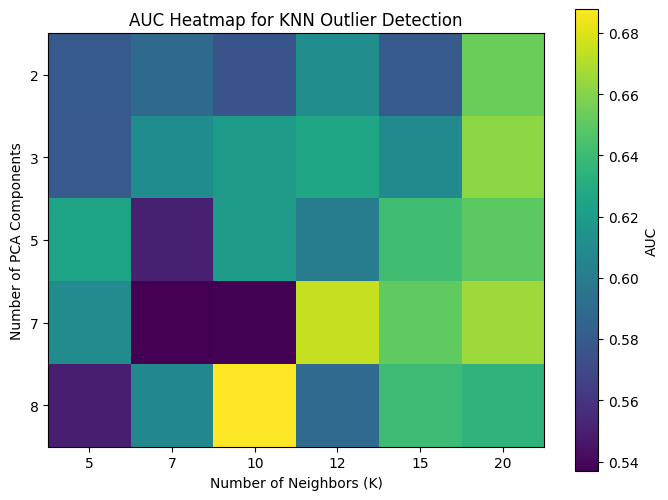

In [17]:
# KNN
# dataset: Pima_withoutdupl_norm_02_v01.csv
import numpy as np
import matplotlib.pyplot as plt

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Pima\\Pima_withoutdupl_norm_02_v01.csv"
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
    
    # Separate data (all columns except the last)
data = df.iloc[:, :-1].values
    
    # Separate labels (last column)
labels = df.iloc[:, -1].values

# Define the hyperparameter ranges
k_values = [5, 7, 10, 12, 15, 20]  # Number of neighbors
n_components_values = [2, 3, 5, 7, 8]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            data, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(labels, predicted_labels, outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

max_auc_index = np.argmax(results['auc'])

# Retrieve the corresponding n_components, k, and AUC
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the results
print(f"Maximum AUC: {max_auc}")
print(f"Corresponding k: {best_k}")
print(f"Corresponding n_components: {best_n_components}")


# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection')
plt.show()


Number of training samples: 407
Testing K values: [3, 5, 7, 9, 11, 13, 15, 17, 19]


C:\Users\asus\AppData\Local\Temp\ipykernel_8160\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_8160\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid thi

Maximum AUC on Validation Set: 0.83
Best k (Number of Neighbors): 5
Best n_components (PCA): 2


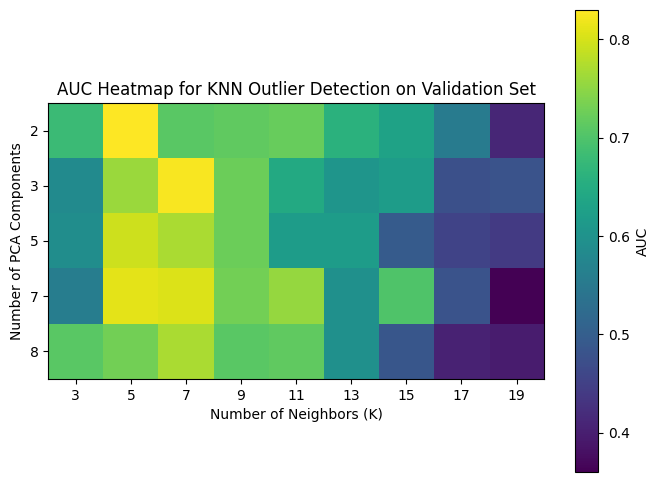

In [10]:
# KNN
# dataset: Pima_withoutdupl_norm_02_v01.csv
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\Pima\\Pima_withoutdupl_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values
print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 8]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


Number of training samples: 356
Testing K values: [3, 5, 7, 9, 11, 13, 15, 17]


C:\Users\asus\AppData\Local\Temp\ipykernel_16496\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_16496\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Best Hyperparameters (from Cross-Validation):
n_components (PCA): 8
k (Number of Neighbors): 17
Average AUC (Cross-Validation): 0.7963065348613421

Test Set Performance:
Precision: 0.0
Recall: 0.0
AUC: 0.37333333333333335


C:\Users\asus\AppData\Local\Temp\ipykernel_16496\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


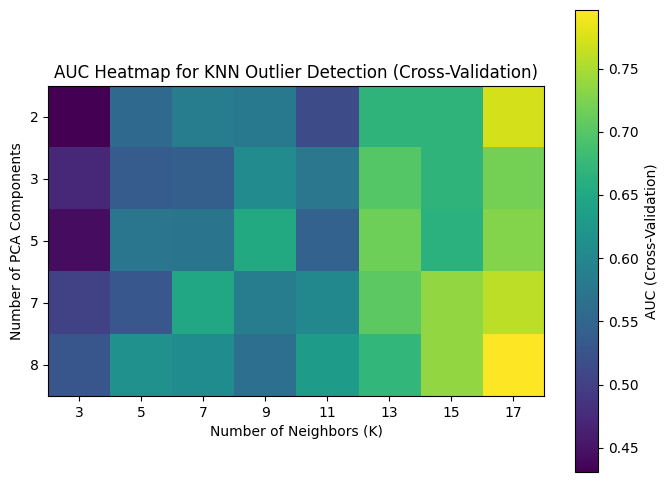

In [26]:
# KNN
# dataset: Pima_withoutdupl_norm_02_v01.csv
# tvt 70 18 12
# cross validation
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

# File path to the dataset
file_path = "G:\\Nazanin\\B project\\code\\dataset\\Pima\\Pima_withoutdupl_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 8]  # Number of PCA components

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
cv_results = []  # To store cross-validation results

# Perform cross-validation
for n_components in n_components_values:
    for k in k_values:
        fold_aucs = []  # To store AUCs for each fold
        for train_idx, val_idx in kf.split(X_train):
            # Split data into training and validation folds
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Calculate KNN outlier scores on the training fold
            _, outlier_scores_fold = calculate_knn_outlier_scores(
                X_train_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Evaluate the performance on the validation fold
            _, val_outlier_scores_fold = calculate_knn_outlier_scores(
                X_val_fold, n_samples=5, sample_fraction=0.8,
                n_components=n_components, n_neighbors=k, contamination=0.1
            )
            
            # Compute the AUC for this fold
            _, _, auc_fold = evaluate_knn_outlier_detection(y_val_fold, _, val_outlier_scores_fold)
            fold_aucs.append(auc_fold)
        
        # Store the average AUC for this hyperparameter combination
        avg_auc = np.mean(fold_aucs)
        cv_results.append((n_components, k, avg_auc))

# Convert CV results to a structured array for analysis
cv_results = np.array(cv_results, dtype=[('n_components', int), ('k', int), ('auc', float)])

# Find the best parameters based on the maximum average AUC
best_index = np.argmax(cv_results['auc'])
best_n_components = cv_results['n_components'][best_index]
best_k = cv_results['k'][best_index]
best_auc = cv_results['auc'][best_index]

print(f"Best Hyperparameters (from Cross-Validation):")
print(f"n_components (PCA): {best_n_components}")
print(f"k (Number of Neighbors): {best_k}")
print(f"Average AUC (Cross-Validation): {best_auc}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"\nTest Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the cross-validation results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        matching_auc = cv_results[(cv_results['n_components'] == n_components) & 
                                  (cv_results['k'] == k)]['auc']
        auc_matrix[i, j] = matching_auc[0] if len(matching_auc) > 0 else 0

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC (Cross-Validation)')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection (Cross-Validation)')
plt.show()


Number of training samples: 254
Testing K values: [3, 5, 7, 9, 11, 13, 15]


C:\Users\asus\AppData\Local\Temp\ipykernel_10332\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10332\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC on Validation Set: 0.8933333333333333
Best k (Number of Neighbors): 9
Best n_components (PCA): 7
Test Set Performance:
Precision: 0.0
Recall: 0.0
AUC: 0.6666666666666667


C:\Users\asus\AppData\Local\Temp\ipykernel_10332\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


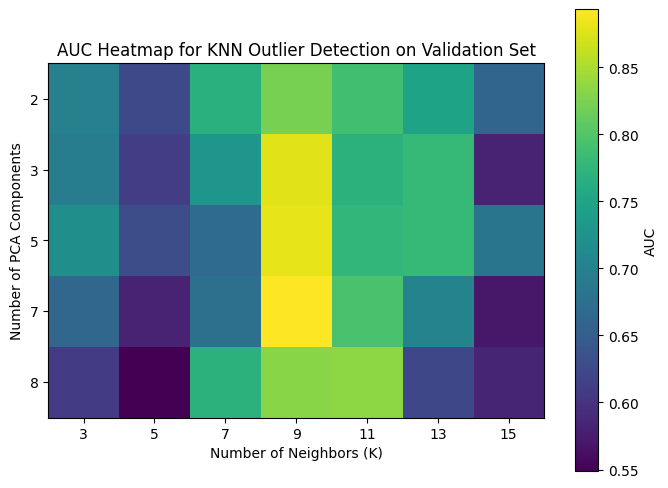

In [32]:
# KNN
# dataset: Arrhythmia_withoutdupl_norm_02_v01.csv
# tvt 60 20 20
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


file_path = "G:\\Nazanin\\B project\\code\\dataset\\Pima\\Pima_withoutdupl_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.5, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 8]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results from validation
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"Test Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()
